In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df =pd.read_csv('C:/Users/user/Downloads/0708/woogawooga_project/dataset_create/Chaeyeon/phishing_data.csv')

df 변수요약

In [2]:
# 기본 변수 요약
summary = pd.DataFrame({
    "Data Type": df.dtypes,
    "Missing (%)": df.isnull().mean() * 100,
    "Unique Values": df.nunique(),
    "Example Value": df.apply(lambda x: x.dropna().unique()[0] if x.dropna().size > 0 else "N/A")
})

# 보기 좋게 정렬
summary = summary.sort_index()

# 출력
print(summary)


              Data Type  Missing (%)  Unique Values      Example Value
file_name        object          0.0           2047       phishing_001
phishing_type    object          0.0              8            가족지인사칭형
speaker           int64          0.0              2                  1
text             object          0.0          39686  아빠? 목소리가 좀 이상한데요.


대화 길이 만들기

In [3]:
# 텍스트 길이
if 'text' in df.columns:
    df['text_len'] = df['text'].astype(str).str.len()
    #plt.hist(df['text_len'], bins=30)
    #plt.title("Text Length Distribution")
    #plt.xlabel("Length")
    #plt.ylabel("Frequency")
    #plt.show()

# file_name 별로 총 길이 합산
total_length_by_file = df.groupby("file_name")["text_len"].sum().reset_index()
total_length_by_file.rename(columns={"text_len": "total_text_len"}, inplace=True)
df2=total_length_by_file

In [4]:
# 문장 길이 분포
df['text_len'].describe()

count    44519.000000
mean        36.092163
std         32.203055
min          1.000000
25%         15.000000
50%         32.000000
75%         51.000000
max        708.000000
Name: text_len, dtype: float64

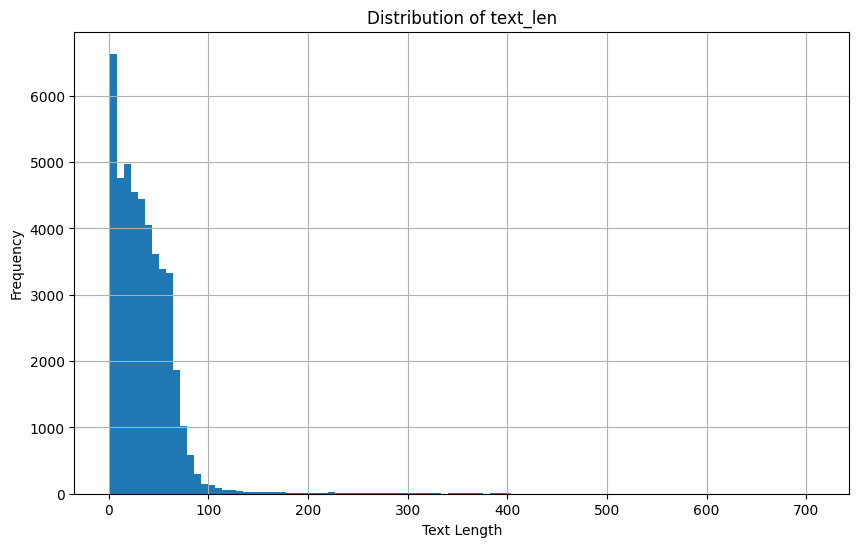

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(df["text_len"], bins=100)
plt.title("Distribution of text_len")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

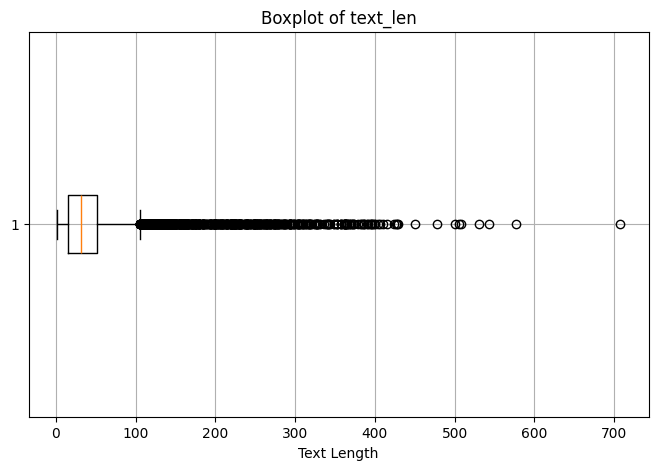

In [6]:
plt.figure(figsize=(8, 5))
plt.boxplot(df["text_len"], vert=False)
plt.title("Boxplot of text_len")
plt.xlabel("Text Length")
plt.grid(True)
plt.show()

In [7]:
#대화 길이 분포
df2['total_text_len'].describe()

count     2047.00000
mean       784.94724
std       1895.63509
min         20.00000
25%        118.00000
50%        187.00000
75%        501.00000
max      23615.00000
Name: total_text_len, dtype: float64

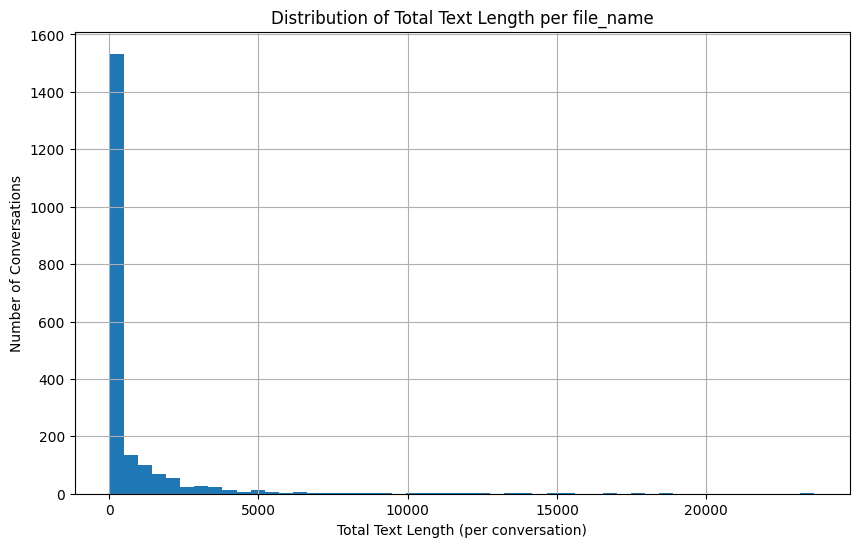

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(total_length_by_file["total_text_len"], bins=50)
plt.title("Distribution of Total Text Length per file_name")
plt.xlabel("Total Text Length (per conversation)")
plt.ylabel("Number of Conversations")
plt.grid(True)
plt.show()

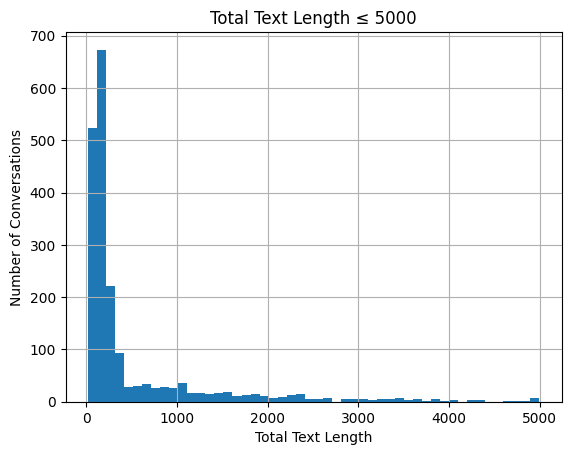

In [9]:
filtered = total_length_by_file[total_length_by_file["total_text_len"] <= 5000]

plt.hist(filtered["total_text_len"], bins=50)
plt.title("Total Text Length ≤ 5000")
plt.xlabel("Total Text Length")
plt.ylabel("Number of Conversations")
plt.grid(True)
plt.show()

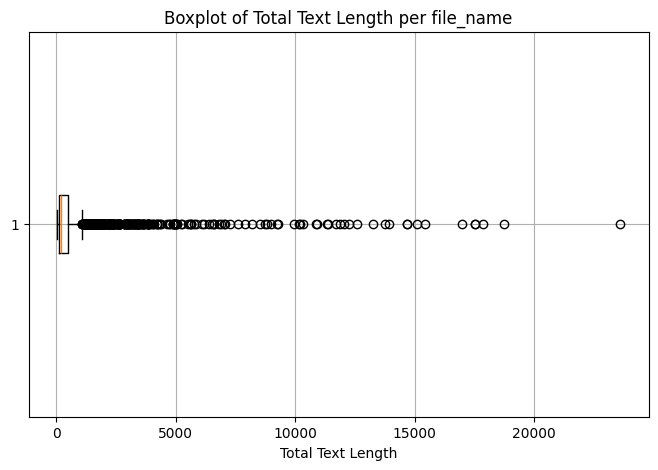

In [10]:
plt.figure(figsize=(8, 5))
plt.boxplot(total_length_by_file["total_text_len"], vert=False)
plt.title("Boxplot of Total Text Length per file_name")
plt.xlabel("Total Text Length")
plt.grid(True)
plt.show()

In [11]:
#문장길이 (극단적) 이상치

# 1. IQR 계산
Q1 = df["text_len"].quantile(0.25)
Q3 = df["text_len"].quantile(0.75)
IQR = Q3 - Q1

# 2. 극단적 이상치 기준
lower_bound_extreme = Q1 - 3.0 * IQR
upper_bound_extreme = Q3 + 3.0 * IQR

# 3. 극단적 이상치만 추출
extreme_outliers = df[
    (df["text_len"] < lower_bound_extreme) |
    (df["text_len"] > upper_bound_extreme)
]
extreme_outliers['text_len'].describe()


count    382.000000
mean     258.314136
std       80.000169
min      160.000000
25%      199.000000
50%      240.000000
75%      298.750000
max      708.000000
Name: text_len, dtype: float64

In [12]:
#대화길이 이상치
Q1 = df2["total_text_len"].quantile(0.25)
Q3 = df2["total_text_len"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 이상치만 필터링
outliers2 = df2[
    (df2["total_text_len"] < lower) |
    (df2["total_text_len"] > upper)
]
#대화길이 이상치 
outliers2.describe()

,total_text_len
count,335.000000
mean,3601.462687
std,3501.971678
min,1090.000000
25%,1565.500000
50%,2313.000000
75%,3808.000000
max,23615.000000


In [13]:
Q1 = df2["total_text_len"].quantile(0.25)
Q3 = df2["total_text_len"].quantile(0.75)
IQR = Q3 - Q1

# 극단적 이상치 기준
lower_extreme = Q1 - 3 * IQR
upper_extreme = Q3 + 3 * IQR

# 대화 길이 극단적 이상치 필터링
extreme_outliers = df2[
    (df2["total_text_len"] < lower_extreme) |
    (df2["total_text_len"] > upper_extreme)
]
extreme_outliers['total_text_len'].describe()

count      240.000000
mean      4488.829167
std       3786.698424
min       1656.000000
25%       2221.500000
50%       3045.500000
75%       4962.250000
max      23615.000000
Name: total_text_len, dtype: float64

대화길이가 극단적 이상치인 대화 유형

In [15]:
# 1. 극단적 이상치 file_name 추출
extreme_file_names = extreme_outliers["file_name"].unique()

# 2. df에서 해당 file_name만 필터링
extreme_df = df[df["file_name"].isin(extreme_file_names)]

# 3. file_name별 phishing_type 대표값 추출 (중복 제거)
file_type_mapping = extreme_df[["file_name", "phishing_type"]].drop_duplicates()

# 4. phishing_type 분포 집계
phishing_type_counts = file_type_mapping["phishing_type"].value_counts(dropna=False)

print(phishing_type_counts)


phishing_type
기관사칭형      155
대출빙자형       73
가족지인사칭형      5
메신저피싱형       3
세금환급형        2
콜백스미싱형       1
투자권유형        1
Name: count, dtype: int64


대화길이가 극단적 이상치인 애들 csv저장

In [16]:
# 1. 극단적 이상치 file_name 리스트
extreme_file_names = extreme_outliers["file_name"].unique()

# 2. 원본 df에서 해당 대화 전체 추출
extreme_df = df[df["file_name"].isin(extreme_file_names)]

# 3. CSV로 저장
extreme_df.to_csv("extreme_outlier_conversations.csv", index=False, encoding="utf-8-sig")
